# Simple ZARC tutorial
This tutorial demonstrates the usage of the `DRT` class to estimate the DRT from impedance data, using simulated data from a simple ZARC circuit as an example.

In [83]:
import numpy as np
import pandas as pd
import os
import sys
import time
import matplotlib.pyplot as plt
%matplotlib notebook
from copy import deepcopy
import glob

if '../bayes-drt' not in sys.path:
    sys.path.append('../bayes-drt')
import drt
from stan_models import save_pickle,load_pickle
import eis_utils as gt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load impedance data

For this example, we use impedance simulated from a circuit consisting of a ZARC element in series with an ohmic resistance. Random noise obeying J.R. Macdonald's proportional error model was added to the exact impedance.

In [2]:
datadir = '../data'

tick_size = 9
label_size = 11

plt.rcParams['font.family'] = 'serif'
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['xtick.labelsize'] = tick_size
plt.rcParams['ytick.labelsize'] = tick_size
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['legend.fontsize'] = tick_size - 1

In [141]:
# load simulated data
circuit = 'ZARC'
err_model = 'Macdonald'
noise_level = 1.0
Zdf = pd.read_csv(os.path.join(datadir,'simulated',f'Z_{circuit}_{err_model}_{noise_level}.csv'))
# make complex impedance array
Zc = Zdf['Zreal'].values + 1j*Zdf['Zimag'].values
# get frequency vector for convenience
freq = Zdf['Freq'].values
# load true drt
g_true = pd.read_csv(os.path.join(datadir,'simulated',f'gamma_{circuit}.csv'))

<IPython.core.display.Javascript object>


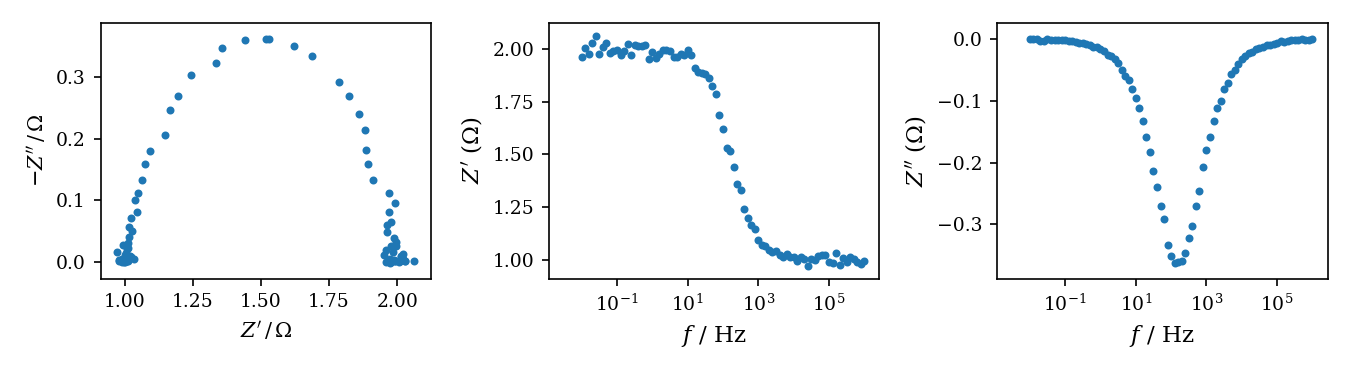

In [142]:
# plot the noisy impedance data
%matplotlib notebook
fig,axes = plt.subplots(1,3,figsize=(9,2.5))
gt.plot_full_eis(Zdf,axes=axes,bode_cols=['Zreal','Zimag'])
fig.tight_layout()

# Hyperparametric ridge fit

This is the method used to obtain initial parameter estimates for the hierarchical Bayesian model, as described in the Supplementary Information. Note that it is not necessary to provide initial parameter estimates; very similar solutions are obtained with and without initial estimates, but the initial estimates can increase the convergence speed of the hierarchical model in some cases. The hyperparametric ridge fit can be performed using the `ridge_fit` method of the `DRT` class.

In [161]:
# create DRT instance
dr_ridge = drt.DRT()

# run hyperparametric ridge fit using the recommended hyperparameter values
start = time.time()
dr_ridge.ridge_fit(freq,Zc,beta=2.5,lambda_0=1e-2)
elapsed = time.time() - start
print('Hyperparametric ridge fit time (including matrix construction): {:.3f} s'.format(elapsed))

# re-run with precalculated matrices 
# (the DRT object stores the last calculated A matrices and reuses them 
# if the frequencies and time constants remain the same)
start = time.time()
dr_ridge.ridge_fit(freq,Zc,beta=2.5,lambda_0=1e-2)
elapsed = time.time() - start
print('Hyperparametric ridge fit time (without matrix construction): {:.3f} s'.format(elapsed))

../bayes-drt\drt.py:1079: RuntimeWarning: overflow encountered in exp
  fit_inductance : bool, optional (default: False)


Hyperparametric ridge fit time (including matrix construction): 6.438 s
Hyperparametric ridge fit time (without matrix construction): 0.048 s


The `ridge_fit` method automatically calculates all required matrices, including the $\mathbf{A}$ matrices, which require numerical evaluation of a number of integrals. By default, the `DRT` class initializes the basis time constants at a density of 10 ppd starting at $1/(2\pi f_1)$ and ending at $1/(2\pi f_N)$. As long as the impedance data is spaced at 10 ppd, this results in the basis time constants being the inverse of the measurement frequencies, and the $\mathbf{A}$ matrices are therefore Toeplitz matrices, such that only the first row and/or column of each matrix needs to be calculated.

The results of the fit can be accessed via the `DRT` object. The `drt` method returns the recovered DRT, while the `predict` method returns the fitted impedance, as shown in the plotting function defined below. When the solution is obtained via MCMC sampling, as in the next section, the `drt` method also takes an optional `percentile` argument, which can be used to generate credibility intervals.

In [106]:
def plot_drt_result(dr,Zdf,g_true,plot_ci=False):
    fig, axes = plt.subplots(2,2,figsize=(7.5,6))
    freq = Zdf['Freq'].values
    
    # plot noisy data
    gt.plot_full_eis(Zdf,axes=axes.ravel()[:3],alpha=0.4,label='Data',bode_cols=['Zreal','Zimag'],s=20)
    # get fitted impedance from DRT instance
    Z_pred = dr.predict(freq)
    df_pred = gt.construct_eis_df(freq,Z_pred)
    # plot impedance fit
    gt.plot_full_eis(df_pred,axes=axes.ravel()[:3],alpha=0.8,label='DRT fit',bode_cols=['Zreal','Zimag'],
                     c='k',plot_func='plot')

    # plot the true DRT
    axes[1,1].plot(g_true['tau'],g_true['gamma'],label='True',ls='--')
    # get the recovered DRT
    g_pred = dr.drt(g_true['tau'])
    # plot the recovered DRT
    if plot_ci:
        # plot mean and 95% credibility interval (CI) if MCMC sampling used
        g_lo = dr.drt(g_true['tau'],percentile=2.5)
        g_hi = dr.drt(g_true['tau'],percentile=97.5)
        axes[1,1].plot(g_true['tau'],g_pred,c='k',label='Posterior mean',alpha=0.8)
        axes[1,1].fill_between(g_true['tau'],g_lo,g_hi,color='k',label='95% CI',alpha=0.15)
    else:
        # otherwise plot point estimate only
        axes[1,1].plot(g_true['tau'],g_pred,c='k',label='Recovered',alpha=0.8)
    
    axes[1,1].set_xscale('log')
    axes[1,1].set_xlabel(r'$\tau$ / s')
    axes[1,1].set_ylabel('$\gamma \ / \ \Omega$')

    for ax in axes.ravel():
        ax.legend()

    fig.tight_layout()

<IPython.core.display.Javascript object>


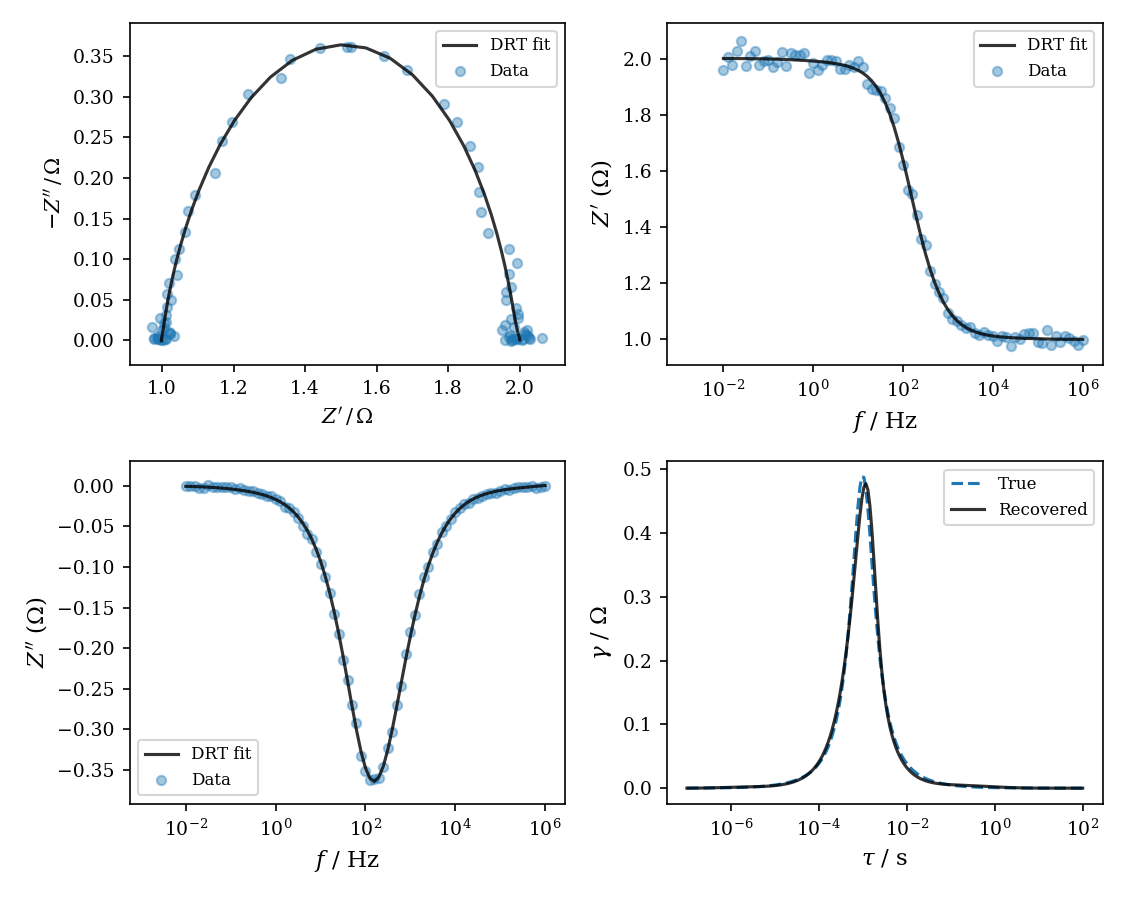

In [144]:
plot_drt_result(dr_ridge,Zdf,g_true)

The figure above shows the DRT fit of the impedance data in a Nyquist plot (top left) and Bode plots of the real (top right) and imaginary (bottom left) components of the impedance, as well as the true and recovered DRTs (bottom right). The hyperparametric solution yields a good estimate of the true DRT in this case; the peak is just slightly distorted from the true shape.
## Obtaining the ohmic resistance and inductance
The ohmic resistance and inductance can be accessed through the `coef_` attribute of the `DRT` class. The first entry of `coef_` is the ohmic resistance, the second entry is the inductance, and the remaining entries are the weighting coefficients of the radial basis functions that comprise the estimated DRT.

In [145]:
print('Ohmic resistance = {:.5f} ohms'.format(dr_ridge.coef_[0]))
print('Inductance = {:.5e} H'.format(dr_ridge.coef_[1]))

Ohmic resistance = 0.99801 ohms
Inductance = 2.27049e-10 H


## Running without the dZ pseudo-prior
The hyperparametric ridge fit may also be performed without the $\frac{dZ}{d \ln{\tau}}$ pseuod-prior, as discussed in the Supplementary Information. To do so, simply specify `dZ=False` in the call to `ridge_fit`.

In [159]:
dr_ridge2 = deepcopy(dr_ridge)
start = time.time()
dr_ridge2.ridge_fit(freq,Zc,beta=2.5,lambda_0=1e-2,dZ=False)
elapsed = time.time() - start
print('Hyperparametric ridge fit time (without dZ pseudo-prior): {:.3f} s'.format(elapsed))

Hyperparametric ridge fit time (without dZ pseudo-prior): 0.025 s


<IPython.core.display.Javascript object>


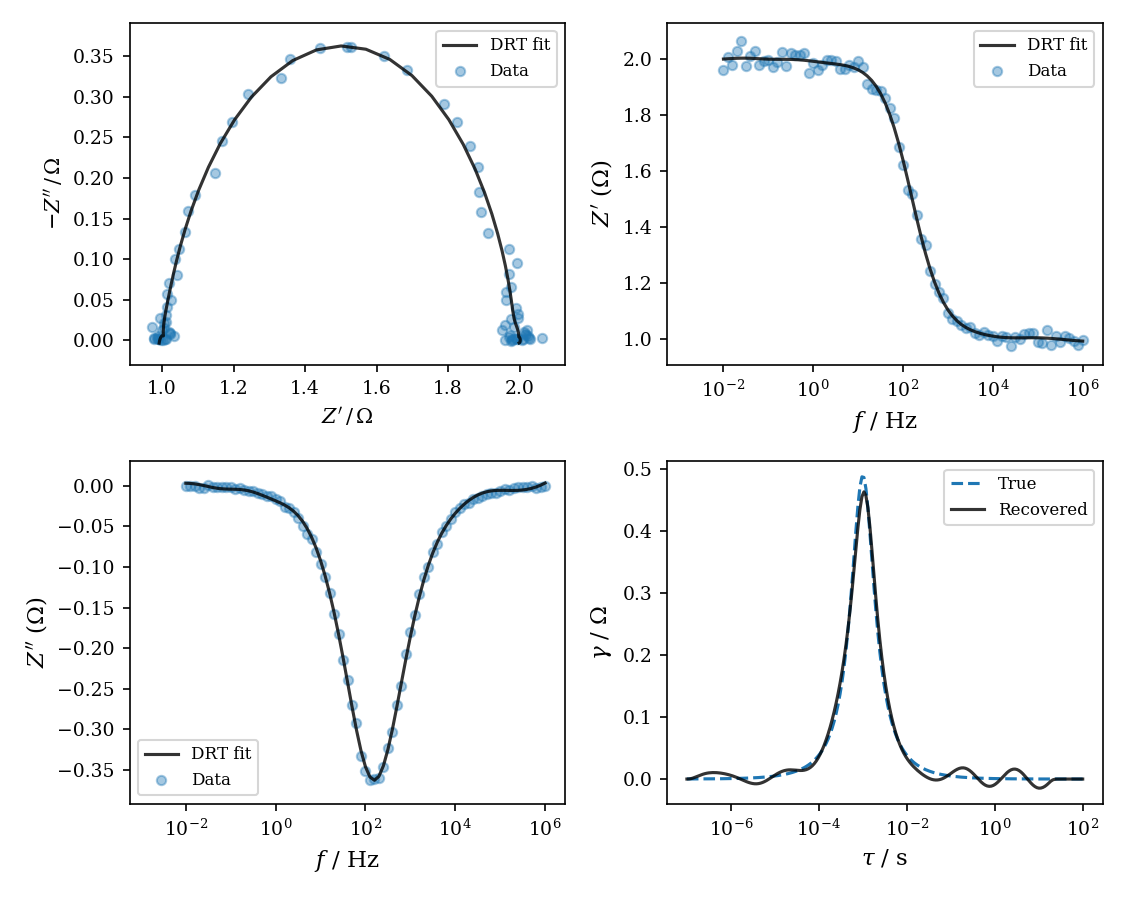

In [160]:
plot_drt_result(dr_ridge2,Zdf,g_true)

Removing the pseudo-prior tends to result in unwanted oscillations and pseudo-peaks, as seen above.

# Hierarchical Bayesian fit via MCMC sampling

Next, we apply the hierarchical Bayesian model and obtain an estimate of the posterior distribution using the Markov Chain Monte Carlo sampler in `Stan`. This approach is accessible via the `bayes_fit` method of the `DRT` class. If you are running your code in a Jupyter notebook, you can monitor sampling progress in the Anaconda Prompt (or other terminal) window.

In [146]:
# sample without obtaining initial parameter estimates from the hyperparametric ridge fit
# copy dr_ridge - A matrices already calculated
dr_mcmc = deepcopy(dr_ridge)
start = time.time()
dr_mcmc.bayes_fit(freq,Zc,init_from_ridge=False)
elapsed = time.time() - start
print('MCMC sampling time (without initial estimates): {:.2f} s'.format(elapsed))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


MCMC sampling time (without initial estimates): 102.51 s


Runtimes for MCMC sampling can vary widely depending on the spectrum, the amount of noise, and the state of the computer. The warning raised above ("Maximum (flat) parameter count exceeded...") simply indicates that diagnostic checks were skipped because there are over 1,000 parameters in the model. This will almost always be the case and is not cause for concern.

<IPython.core.display.Javascript object>


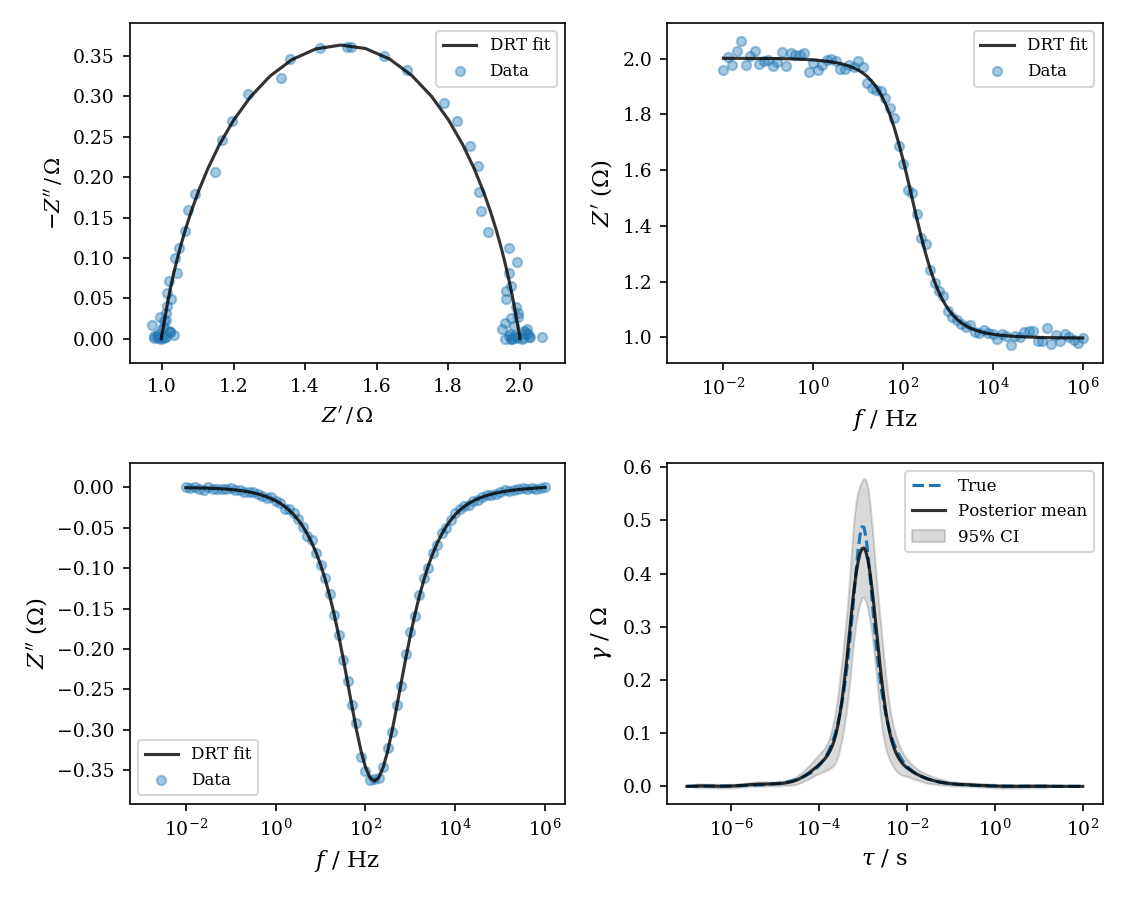

In [147]:
plot_drt_result(dr_mcmc,Zdf,g_true,plot_ci=True)

The solution obtained by MCMC sampling is an estimate of the full posterior distribution; i.e., a distribution of values for each parameter in the model (and $\gamma(\tau)$ at every value of $\tau$). This distribution can be represented by the mean of the posterior distribution, indicated by the black line, and the credibility interval (CI), which indicates in light gray the area between the 2.5th percentile and 97.5th percentile of the posterior distribution. For this spectrum, the peak of the posterior mean is slightly depressed from the true value, but it is not distorted as in the hyperparametric ridge solution. The CI encompasses the true value of the DRT across all $\tau$.

In [29]:
# re-sample, this time providing initial parameter estimates from the hyperparametric ridge fit
dr_mcmc2 = deepcopy(dr_ridge)
start = time.time()
dr_mcmc2.bayes_fit(freq,Zc,init_from_ridge=True)
elapsed = time.time() - start
print('MCMC sampling time (with initial estimates): {:.2f} s'.format(elapsed))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


MCMC sampling time (with initial estimates): 62.12 s


<IPython.core.display.Javascript object>


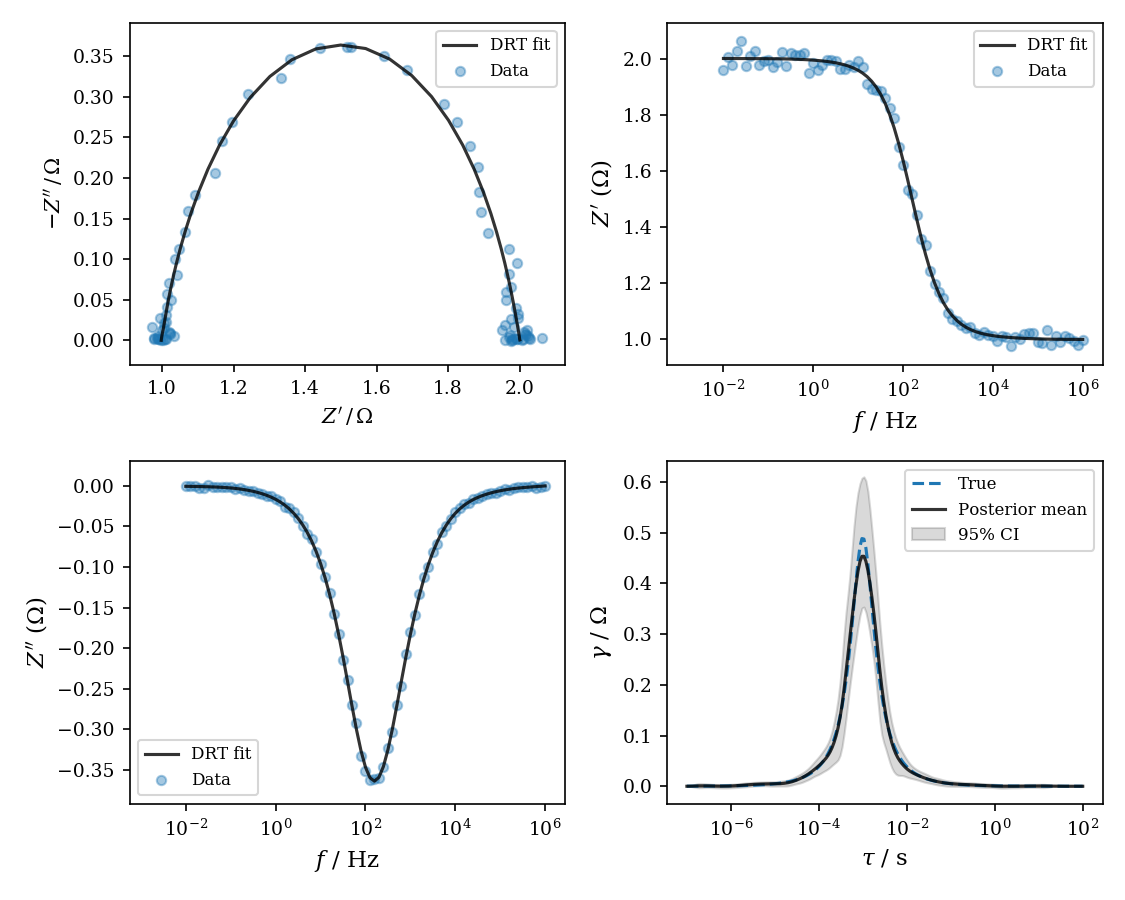

In [30]:
plot_drt_result(dr_mcmc2,Zdf,g_true,plot_ci=True)

The solutions obtained with and without initial parameter estimates are nearly identical, but the sampling runs ~3-12 s faster **without** initial parameter estimates (runtimes vary). For more complex spectra, providing initial estimates generally *reduces* the runtime, in contrast to this scenario.

## Predicting the error structure
The hierarchical Bayesian model also provides estimates of the error structure of the impedance, accessible via the `predit_err_scale` method. The error structure is quantified by the standard deviation (or scale) of the error at each measurement frequency.

In [166]:
def plot_resid(dr,Zdf):
    fig,axes = plt.subplots(1,2,figsize=(7.5,3),sharex=True)
    freq = Zdf['Freq'].values
    Zc = Zdf['Zreal'].values + 1j*Zdf['Zimag'].values
    
    # plot residuals
    Z_pred = dr.predict(freq)
    df_err = gt.construct_eis_df(freq,Z_pred-Zc)
    gt.plot_bode(df_err,axes=axes,cols=['Zreal','Zimag'],alpha=0.4,s=20,label='Residuals',unit_scale='')

    # plot true error scale
    p = axes[0].plot(freq,3*Zdf['sigma_re'],ls='--',label='True $\pm 3\sigma$')
    axes[0].plot(freq,-3*Zdf['sigma_re'],ls='--',c=p[0].get_color())
    axes[1].plot(freq,3*Zdf['sigma_im'],ls='--')
    axes[1].plot(freq,-3*Zdf['sigma_im'],ls='--',c=p[0].get_color())

    # get the recovered error scale
    sigma_re, sigma_im = dr.predict_err_scale(freq)
    # plot recovered error scale
    axes[0].fill_between(freq,-3*sigma_re,3*sigma_re,color='k',alpha=0.15,label='Recovered $\pm3\sigma$')
    axes[1].fill_between(freq,-3*sigma_im,3*sigma_im,color='k',alpha=0.15)

    axes[0].legend()
    #make room for legend
    axes[0].set_ylim(-0.1,0.1)
    axes[0].set_xlim(1e-3,1e7)
    
    fig.tight_layout()

<IPython.core.display.Javascript object>


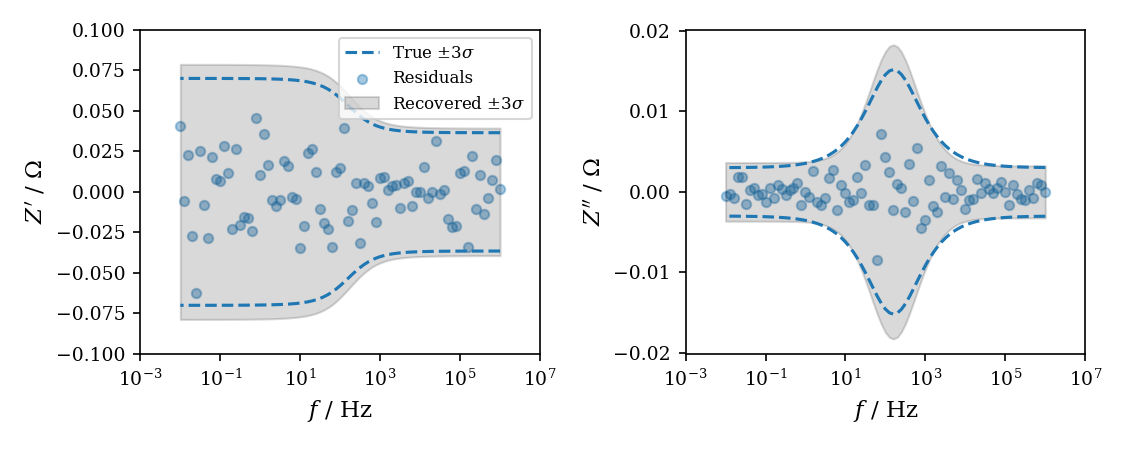

In [167]:
plot_resid(dr_mcmc,Zdf)

The recovered error scale is qualitatively accurate for this spectrum, but slightly overestimates the error level.

# Hierarchical Bayesian fit via MAP optimization
Finally, we obtain a maximum *a posteriori* (MAP) of the DRT by maximizing the hierarchical Bayesian posterior probability using the L-BFGS algorithm implemented in `Stan`. This enables the hierarchical model to be fitted to the data much more quickly than is possible via MCMC sampling. This approach is accessible via the `map_fit` method.

In [153]:
# run MAP optimization without initial parameter estimates
dr_map = deepcopy(dr_ridge)
start = time.time()
dr_map.map_fit(freq,Zc,init_from_ridge=False)
elapsed = time.time() - start
print('MAP optimization time (without initial estimates): {:.2f} s'.format(elapsed))

MAP optimization time (without initial estimates): 3.16 s


<IPython.core.display.Javascript object>


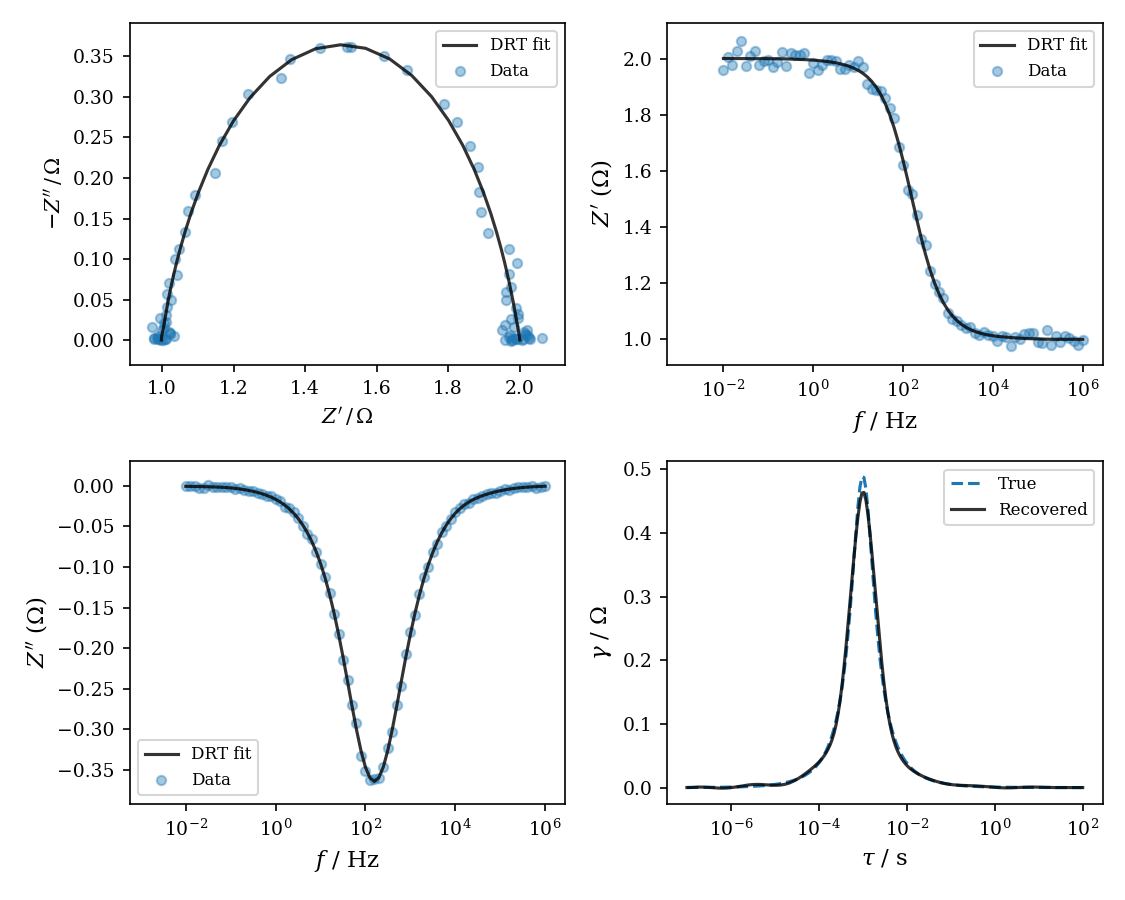

In [150]:
plot_drt_result(dr_map,Zdf,g_true)

The MAP point estimate very closely matches the posterior mean from MCMC sampling, but is obtained ~30 times faster.

In [151]:
# run MAP optimization WITH initial parameter estimates
dr_map2 = deepcopy(dr_ridge)
start = time.time()
dr_map2.map_fit(freq,Zc,init_from_ridge=True)
elapsed = time.time() - start
print('MAP optimization time (with initial estimates): {:.2f} s'.format(elapsed))

MAP optimization time (with initial estimates): 3.99 s


<IPython.core.display.Javascript object>


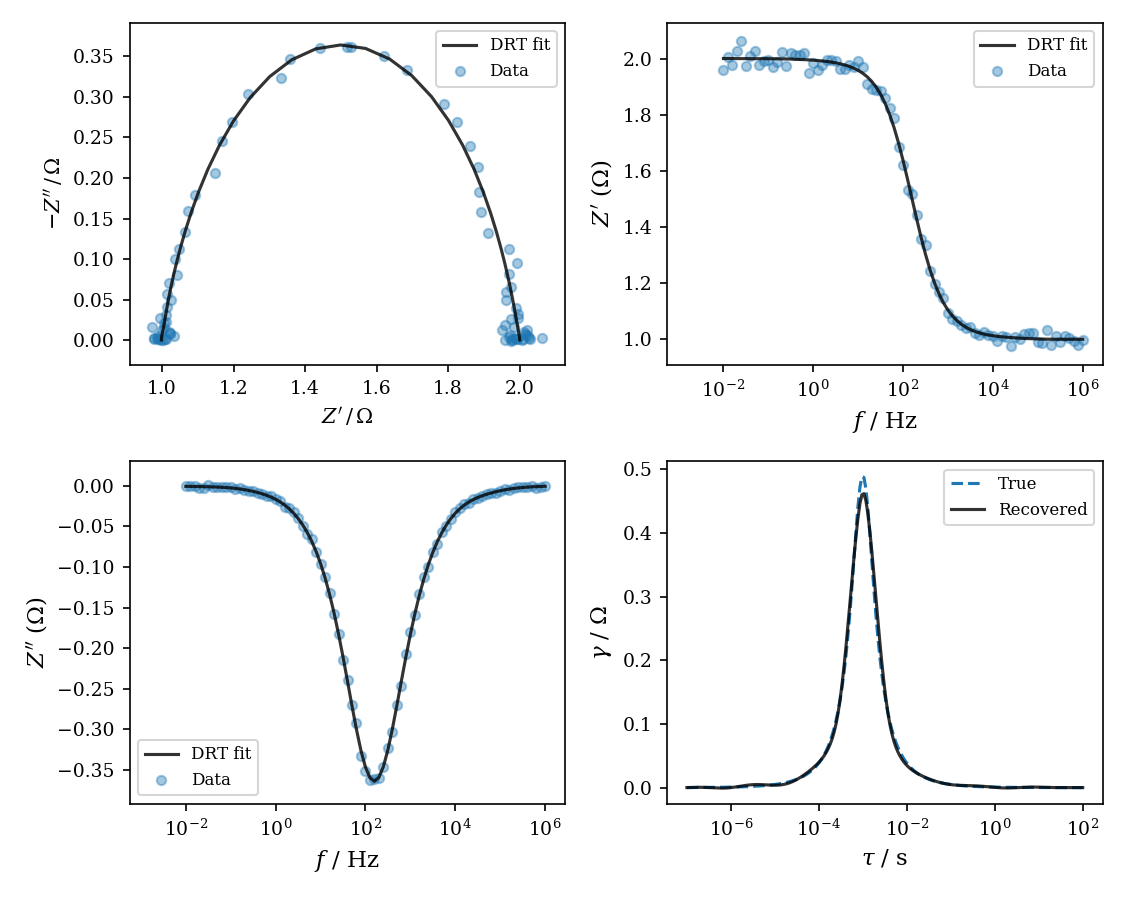

In [152]:
plot_drt_result(dr_map2,Zdf,g_true)

Once again, providing initial parameter estimates from the hyperparametric ridge fit marginally increases the runtime for this spectrum.

Like the MCMC solution, the MAP solution also provides an estimate of the error scale.

<IPython.core.display.Javascript object>


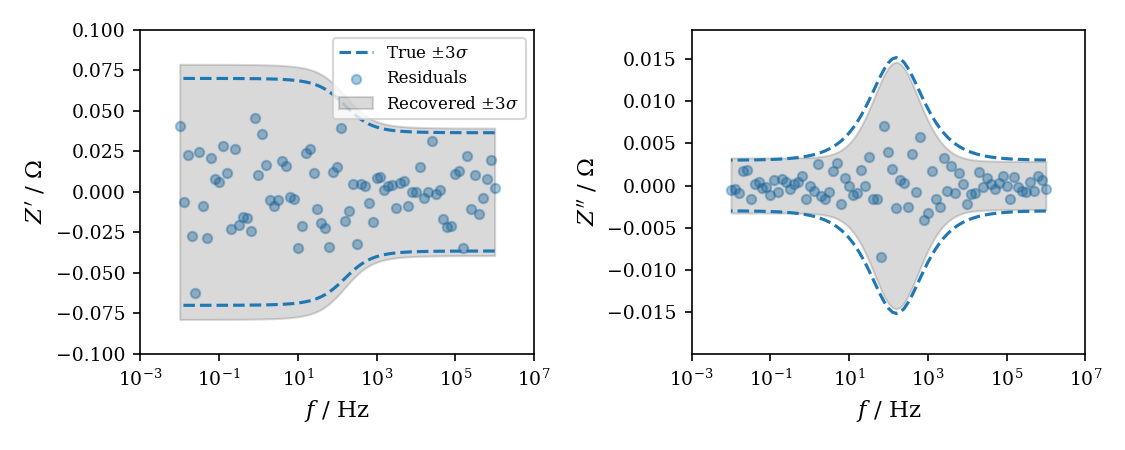

In [168]:
plot_resid(dr_map,Zdf)

## Enforcing non-negativity
Each fitting method can be applied with a non-negativity constraint (as has traditionally been used for the DRT) by passing the argument `nonneg=True`, as shown below for the MAP optimization. The results are generally nearly identical, since the methods implemented are quite robust to pseudo-peaks and extraneous oscillations.

In [129]:
# run MAP optimization with non-negativity constraint
dr_map3 = deepcopy(dr_ridge)
start = time.time()
dr_map3.map_fit(freq,Zc,init_from_ridge=False,nonneg=True)
elapsed = time.time() - start
print('MAP optimization time (with initial estimates): {:.2f} s'.format(elapsed))

MAP optimization time (with initial estimates): 1.55 s


<IPython.core.display.Javascript object>


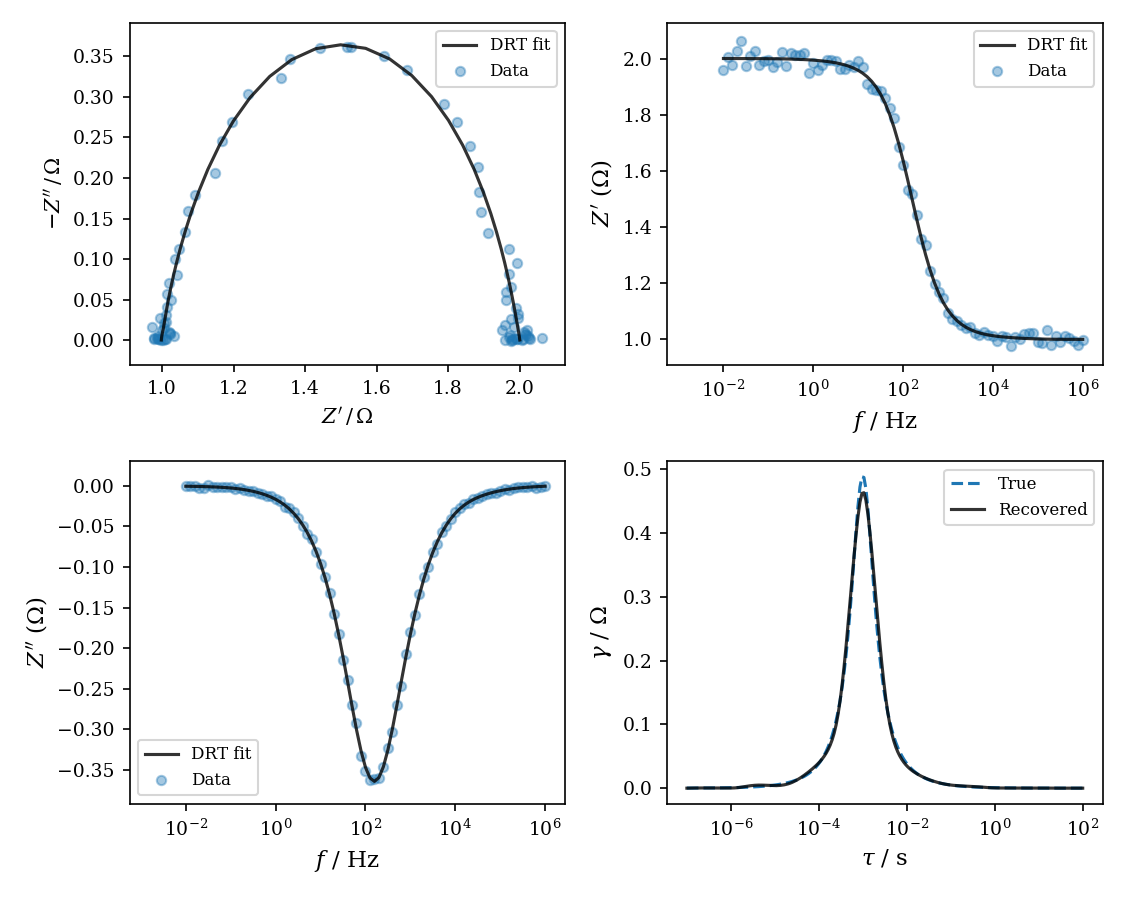

In [128]:
plot_drt_result(dr_map3,Zdf,g_true)

As stated above, the recovered DRT is nearly identical to the solution obtained without a non-negativity constraint, although the slight oscillation near $10^{-7} \ \mathrm{s} < \tau < 10^{-5} \ \mathrm{s}$ is marginally reduced with the non-negativity constraint.